In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import os
#thanks @keskarnitish

# Generate names
* Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train NN instead.
* Dataset contains ~8k human names from different cultures[in latin transcript]
* Objective (toy problem): learn a generative model over names.

In [4]:
start_token = " "

with open("names") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token+name for name in names]

In [5]:
print ('n samples = ',len(names))
for x in names[::1000]:
    print (x)

n samples =  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


# Text processing

In [6]:
#all unique characters go here
tokens = set()
for name in names:
    for letter in name:
        tokens.add(letter)

tokens = list(tokens)
print ('n_tokens = ',len(tokens))


n_tokens =  55


In [7]:
#!token_to_id = <dictionary of symbol -> its identifier (index in tokens list)>
token_to_id = {t:i for i,t in enumerate(tokens) }

#!id_to_token = < dictionary of symbol identifier -> symbol itself>
id_to_token = {i:t for i,t in enumerate(tokens)}

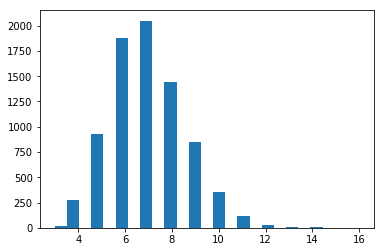

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(list(map(len, names)), bins=25);

# truncate names longer than ~80% percentile
MAX_LEN = int(np.percentile(list(map(len, names)), 80))

### Cast everything from symbols into identifiers

In [9]:
names_ix = list(map(lambda name: list(map(token_to_id.get,name)),names))


#crop long names and pad short ones
for i in range(len(names_ix)):
    names_ix[i] = names_ix[i][:MAX_LEN] #crop too long
    
    if len(names_ix[i]) < MAX_LEN:
        names_ix[i] += [token_to_id[" "]]*(MAX_LEN - len(names_ix[i])) #pad too short
        
assert len(set(map(len,names_ix)))==1

names_ix = np.array(names_ix)

# Input variables

In [10]:
input_sequence = T.matrix('token sequencea','int32')
target_values = T.matrix('actual next token','int32')

# Build NN

You will be building a model that takes token sequence and predicts next token


* iput sequence
* one-hot / embedding
* recurrent layer(s)
* otput layer(s) that predict output probabilities


In [11]:
from lasagne.layers import InputLayer,DenseLayer,EmbeddingLayer
from lasagne.layers import RecurrentLayer,LSTMLayer,GRULayer,CustomRecurrentLayer

In [12]:
l_in = lasagne.layers.InputLayer(shape=(None, None),input_var=input_sequence)

#!<Your neural network>
l_emb = EmbeddingLayer(l_in, input_size=len(tokens), output_size=30)

l_rnn = LSTMLayer(l_emb, num_units=64)

#flatten batch and time to be compatible with feedforward layers (will un-flatten later)
l_rnn_flat = lasagne.layers.reshape(l_rnn, (-1,l_rnn.output_shape[-1]))

l_out = DenseLayer(l_rnn_flat, len(tokens),nonlinearity=T.nnet.softmax)

In [13]:
# Model weights
weights = lasagne.layers.get_all_params(l_out,trainable=True)
print( weights)

[W, W_in_to_ingate, W_hid_to_ingate, b_ingate, W_in_to_forgetgate, W_hid_to_forgetgate, b_forgetgate, W_in_to_cell, W_hid_to_cell, b_cell, W_in_to_outgate, W_hid_to_outgate, b_outgate, W_cell_to_ingate, W_cell_to_forgetgate, W_cell_to_outgate, W, b]


In [14]:
network_output = lasagne.layers.get_output(l_out)

In [15]:
predicted_probabilities_flat = network_output
correct_answers_flat = target_values.ravel()


loss = lasagne.objectives.categorical_crossentropy(predicted_probabilities_flat, correct_answers_flat).mean()

updates = lasagne.updates.adam(loss, weights)

# Compiling it

In [16]:
#training
train = theano.function([input_sequence, target_values], loss, updates=updates, allow_input_downcast=True)

#computing loss without training
compute_cost = theano.function([input_sequence, target_values], loss, allow_input_downcast=True)

# generation

Simple: 
* get initial context(seed), 
* predict next token probabilities,
* sample next token, 
* add it to the context
* repeat from step 2

You'll get a more detailed info on how it works in the homework section.

In [17]:
#compile the function that computes probabilities for next token given previous text.

#reshape back into original shape
next_word_probas = network_output.reshape((input_sequence.shape[0],input_sequence.shape[1],len(tokens)))
#predictions for next tokens (after sequence end)
last_word_probas = next_word_probas[:,-1]
probs = theano.function([input_sequence],last_word_probas,allow_input_downcast=True)


In [18]:

def generate_sample(seed_phrase=None,N=MAX_LEN,t=1,n_snippets=1):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
        
    parameters:
        sample_fun - max_ or proportional_sample_fun or whatever else you implemented
        
        The phrase is set using the variable seed_phrase

        The optional input "N" is used to set the number of characters of text to predict.     
    '''
    if seed_phrase is None:
        seed_phrase=start_token
    if len(seed_phrase) > MAX_LEN:
        seed_phrase = seed_phrase[-MAX_LEN:]
    assert type(seed_phrase) is str

    snippets = []
    for _ in range(n_snippets):
        sample_ix = []
        x = [token_to_id.get(c,0) for c in seed_phrase]
        x = np.array([x])

        for i in range(N):
            # Pick the character that got assigned the highest probability
            p = probs(x).ravel()
            p = p**t / np.sum(p**t)
            ix = np.random.choice(np.arange(len(tokens)),p=p)
            sample_ix.append(ix)

            x = np.hstack((x[-MAX_LEN+1:],[[ix]]))

        random_snippet = seed_phrase + ''.join(id_to_token[ix] for ix in sample_ix)    
        snippets.append(random_snippet)
        
    print("----\n %s \n----" % '; '.join(snippets))


# Model training

Here you can tweak parameters or insert your generation function


__Once something word-like starts generating, try increasing seq_length__



In [19]:
def sample_batch(data, batch_size):
    
    rows = data[np.random.randint(0,len(data),size=batch_size)]
    
    return rows[:,:-1],rows[:,1:]

In [22]:

print("Training ...")


#total N iterations
n_epochs=100

# how many minibatches are there in the epoch 
batches_per_epoch = 500

#how many training sequences are processed in a single function call
batch_size=10


for epoch in range(n_epochs):

    print("Generated names")
    generate_sample(n_snippets=10)

    avg_cost = 0;
    
    for _ in range(batches_per_epoch):
        
        x,y = sample_batch(names_ix,batch_size)
        avg_cost += train(x, y)
        
    print("Epoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch))



Training ...
Generated names
----
  tYgrjsaz;  tTlTKzaD;  FIFMjCGF;  g gXerdq;  MVbXkfrU;  SAoKkioK;  CpxUpRXI;  uhKCBoDk;  DGOieZcC;  bOQVo lj 
----
Epoch 0 average loss = 2.772272753715515
Generated names
----
  Cancyie ;  Duraret ;  Medina  ;  Prneta h;  C lsdia ;  Cospi   ;  Rwasic i;  Ptadtie ;  Manna   ;  hourta   
----
Epoch 1 average loss = 2.2609855868816378
Generated names
----
  Gohiesn ;  Larel   ;  cadiy   ;  Mhatdten;  Manrutte;  Lacdena ;  Btyxee  ;  Renlis  ;  Ig      ;  Claw     
----
Epoch 2 average loss = 2.1861377372741697
Generated names
----
  Lalcy   ;  Hard    ;  Dacveela;  Cotthegs;  Berglina;  Aratkuu ;  Jortseed;  Kivan   ;  Jastie  ;  Eunlyort 
----
Epoch 3 average loss = 2.1400229790210723
Generated names
----
  Valled  ;  Mawna   ;  Gallicke;  Suszong ;  Heviena ;  Adidornc;  Wininsa ;  Kane    ;  Gtonarin;  Retuo    
----
Epoch 4 average loss = 2.103325899839401
Generated names
----
  Laonna  ;  Sharyn  ;  Artella ;  Bamnurn ;  Karieden;  Shanison;  Lelis

In [23]:
generate_sample(n_snippets=100)

----
  Mattis  ;  Damily  ;  Ag      ;  Orelle  ;  Missey  ;  Adrienna;  Mabel   ;  Amil    ;  Frane   ;  Madelaid;  Dem     ;  Jess    ;  Loren   ;  Prysel  ;  Hannelis;  Cyrilla ;  Ernest  ;  Saothron;  Angemi  ;  Janess  ;  Aldne   ;  Jerrie  ;  Carley  ;  Haugus  ;  Harlanie;  Zacherik;  Pate    ;  Fariana ;  Caretta ;  Almurden;  Antonnia;  Gilb    ;  Chaspen ;  Evvinga ;  Cessie  ;  Leonard ;  Delma   ;  Salman  ;  Terrella;  Kenthio ;  Ansel   ;  Mari    ;  Geordra ;  Shelbeo ;  Mischa  ;  Ala     ;  Moly    ;  Obie    ;  Terida  ;  Carson  ;  Chala   ;  Willab  ;  Dorette ;  Chasta  ;  Adory   ;  Johnni  ;  Heydoldo;  Aldris  ;  Melin   ;  Erni    ;  Don     ;  Alene   ;  Leolea  ;  Clarite ;  Melestet;  Haustyn ;  Dortham ;  Ilda    ;  Silly   ;  Gussi   ;  Taslie  ;  Cristin ;  Steffani;  Rosemarr;  Gertror ;  Ricki   ;  Shelson ;  Lyshal  ;  Erina   ;  Mohana  ;  Cybrola ;  Silvel  ;  Adrick  ;  Elvore  ;  Patia   ;  JackAl  ;  Violette;  Hanny   ;  Frent   ;  Orsola  ;  Hal

In [25]:
generate_sample(seed_phrase=" A")

----
  Aviva     
----
